<span style="font-family: Arial; font-size: 30px; color: rgb(0, 166, 153); font-weight: bold;">Analiza statistică a locuințelor Airbnb</span>


---
<span style="font-family: Arial; font-size: 20px; color: rgb(255, 90, 95); font-weight: bold;">Următoarea destinație: Amsterdam, Atena, Barcelona, Berlin, Budapesta, Lisabona, Paris, Roma sau Viena?</span>




Obiective:
Proiectul își propune o analiză statistică detaliată a diveristății ofertelor disponibile pe platforma de închiriere Airbnb, pentru 9 dintre cele mai vizitate orașe din Europa, așadar prezentarea vizează:
- ghidarea potențialilor călători în a găsi mai ușor destinații potrivite preferințelor lor, grupând locuințele cu caracteristici similare printr-o ***analiză Cluster*** ce folosește ***algoritmul K-Means***. A fost folosit în primă fază ***algoritmul ierarhic Ward*** pentru identificarea numărului optim de clustere în care să fie grupate observațiile.
- predicția satisfacției clienților în funcție de caracteristicile locuințelor pe care le aleg, pentru a oferi o estimare așteptată a nivelului de satisfacție, folosind un ***model de regresie liniară multifactorială***, ce a fost comparat ulterior performanța unui model de regresie ce folosește ***Extreme Gradient Boosting*** pentru a antrena modelul.

## Import librării

In [1]:
# Librării basic
import pandas as pd
import numpy as np

In [2]:
# Librării preprocesare date
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn import preprocessing

In [3]:
# Librării pentru metrici de performanță
from sklearn import metrics
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import silhouette_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score

In [4]:
# Librării pentru vizualizarea datelor
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
import pylab as pl
%matplotlib inline

In [5]:
# Librării pentru modele statistice
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sklearn
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import f, t
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn import linear_model
from scipy import stats
import xgboost as xgb
from xgboost import XGBRegressor
import seaborn as sns
import statsmodels.api as sm

## Importul bazei de date

In [6]:
# Pentru lucrul în Google Colab, pentru a facilita citirea fișierului
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
airbnb_df=pd.read_csv("/content/drive/MyDrive/Seminar_Machine_Learning/airbnb_corectat.csv")


# Extrage un eșantion aleator de 200 de înregistrări
#sample_df = airbnb_df.sample(n=200, random_state=42)  # random_state pentru reproducibilitate

# Salvează eșantionul într-un fișier CSV separat
#sample_df.to_csv('airbnb.csv', index=False)

#print("Eșantionul a fost salvat în eșantion.csv.")

## Înțelegerea datelor

Baza de date utilizată în analiză are ca sursă Kaggle: https://www.kaggle.com/datasets/dipeshkhemani/airbnb-cleaned-europe-dataset/data

Pentru eficientizarea resurselor și rapiditatea rulării codului, din baza de date inițială de 41.714 înregistrări, a fost extras aleator un eșantion de 200 de înregistrări. Script-ul a fost testat și pentru o bază de date de 1000 înregistrări, însă rezultatele erau similare cu rularea acestuia pentru 200 de înregistrări, așadar pentru simplificare, a fost păstrat eșantionul cu mai puține observații.

Este un set de date ce conține informații privind apartamente înregistrate pe platforma Airbnb destinantă închirierii de apartamente, camere sau case pentru 9 orașe des vizitate din Europa.


In [8]:
#Afișarea primelor linii din tabel, care ne asigură că baza de date a fost corect importată

airbnb_df.head()

,City,Price,Day,Room Type,Shared Room,Private Room,Person Capacity,Superhost,Multiple Rooms,Business,Cleanliness Rating,Guest Satisfaction,Bedrooms,City Center (km),Metro Distance (km)
0,Budapest,97.47,Weekday,Entire home/apt,False,False,3,False,0,1,9,88,1,2.74,1.12
1,Rome,122.00,Weekend,Entire home/apt,False,False,2,False,0,1,7,73,1,5.15,2.77
2,Athens,48.60,Weekend,Entire home/apt,False,False,2,True,0,1,8,70,1,7.61,3.31
3,Paris,614.22,Weekday,Entire home/apt,False,False,2,False,1,0,7,65,1,11.72,3.74
4,Amsterdam,1563.92,Weekend,Entire home/apt,False,False,2,False,0,1,10,100,1,2.41,0.05


## Pre-procesarea datelor

Pentru a face mai ușor de urmărit baza de date, numele variabilelor au fost simplificate prin eliminarea spațiilor dintre cuvinte și a parantezelor pentru variabilelel la care se menționează unitatea de măsură (km). Acestea au fost înlocuite cu _

In [9]:
airbnb_df.columns = airbnb_df.columns.str.lower()
airbnb_df.columns = airbnb_df.columns.str.replace(' ', '_')
airbnb_df.columns = airbnb_df.columns.str.replace('(', '')
airbnb_df.columns = airbnb_df.columns.str.replace(')', '')
airbnb_df.head()

<ipython-input-9-5e6275cd59f0>:3: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.

<ipython-input-9-5e6275cd59f0>:4: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



,city,price,day,room_type,shared_room,private_room,person_capacity,superhost,multiple_rooms,business,cleanliness_rating,guest_satisfaction,bedrooms,city_center_km,metro_distance_km
0,Budapest,97.47,Weekday,Entire home/apt,False,False,3,False,0,1,9,88,1,2.74,1.12
1,Rome,122.00,Weekend,Entire home/apt,False,False,2,False,0,1,7,73,1,5.15,2.77
2,Athens,48.60,Weekend,Entire home/apt,False,False,2,True,0,1,8,70,1,7.61,3.31
3,Paris,614.22,Weekday,Entire home/apt,False,False,2,False,1,0,7,65,1,11.72,3.74
4,Amsterdam,1563.92,Weekend,Entire home/apt,False,False,2,False,0,1,10,100,1,2.41,0.05


În baza de date există variabile ce conțin valori booleene, așadar am dorit să fie convertite în variabile tip șir de caractere pentru a fi mai ușor de manipulat. În acest sens, a fost realizată o asociere cu șirurile ***True*** și ***False***.

In [10]:
airbnb_df['shared_room'] = airbnb_df['shared_room'].map({True: 'True', False: 'False'})
airbnb_df['private_room'] = airbnb_df['private_room'].map({True: 'True', False: 'False'})

In [11]:
airbnb_df.isna().sum()

city                  0
price                 0
day                   0
room_type             0
shared_room           0
private_room          0
person_capacity       0
superhost             0
multiple_rooms        0
business              0
cleanliness_rating    0
guest_satisfaction    0
bedrooms              0
city_center_km        0
metro_distance_km     0
dtype: int64

Se observă că nu există valori lipsă în baza de date, așadar se poate trece la partea de explorare a datelor.

# Explorarea datelor

In [12]:
airbnb_df.shape

(200, 15)

Baza de date folosită în continuare în analiză are 200 de înregistrări și 15 variabile.

In [13]:
airbnb_df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,200.0,404.92650,324.501063,48.60,132.4375,292.810,622.5375,1751.46
person_capacity,200.0,3.14000,1.280075,2.00,2.0000,3.000,4.0000,6.00
multiple_rooms,200.0,0.31000,0.463654,0.00,0.0000,0.000,1.0000,1.00
business,200.0,0.27500,0.447635,0.00,0.0000,0.000,1.0000,1.00
cleanliness_rating,200.0,9.59500,0.687998,7.00,9.0000,10.000,10.0000,10.00
guest_satisfaction,200.0,94.03500,6.638079,65.00,92.0000,96.000,98.0000,100.00
bedrooms,200.0,1.31000,0.675412,0.00,1.0000,1.000,2.0000,3.00
city_center_km,200.0,2.97830,2.028040,0.15,1.4975,2.625,3.9325,14.97
metro_distance_km,200.0,0.66255,0.694764,0.05,0.2500,0.420,0.7775,3.95


***INTERPRETARE***

1. Se observă măsuri diferite pentru variabile, așadar datele vor fi standardizate pentru a păstra omogenitatea.
2. Valorile înregistrare pentru variabila ***price*** sunt mari, comparativ cu restul variabilelor, așadar aceasta necesită mai multă atenție în ceea ce privește analiza.
3. Prin calculul aproximativ al coeficientului de variație, împărțind std/mean, se observă că valorile depășesc pragul de 0,35, așadar datele sunt eterogene.

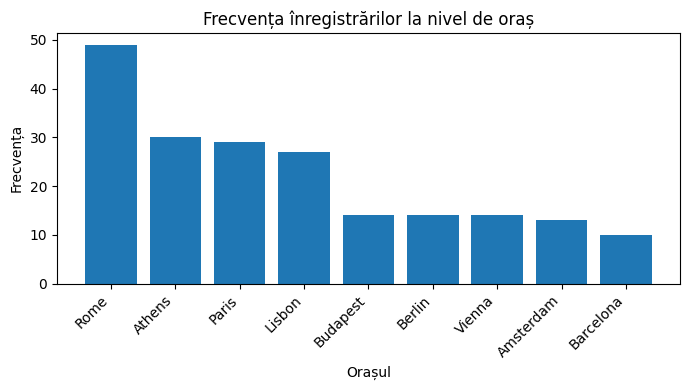

In [14]:
# Calcului frecvențelor pentru fiecare oraș
city_frec = airbnb_df['city'].value_counts()

# Plot bar chart
plt.figure(figsize=(7, 4))
plt.bar(city_frec.index, city_frec.values, color='tab:blue')
plt.xlabel('Orașul')
plt.ylabel('Frecvența')
plt.title('Frecvența înregistrărilor la nivel de oraș')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

***INTERPRETARE***

Orașul pentru care există cele mai multe înregistrări este Roma, iar pentru Barcelona sunt cele mai puține.

### Grupare și agregare, pentru a realiza o primă comparație între orașe

In [15]:
pret_mediu_per_oras = airbnb_df.groupby('city')['price'].mean().round(2).sort_values(ascending=False)
pret_mediu_per_oras

city
Amsterdam    1048.08
Paris         785.44
Barcelona     630.15
Lisbon        512.31
Vienna        499.71
Rome          231.02
Berlin        190.85
Budapest      108.12
Athens         64.91
Name: price, dtype: float64

In [16]:
nivel_mediu_satisfactie_per_oras = airbnb_df.groupby('city')['guest_satisfaction'].mean().round(2).sort_values(ascending=False)
nivel_mediu_satisfactie_per_oras

city
Vienna       96.07
Amsterdam    95.85
Budapest     95.64
Barcelona    94.80
Berlin       94.14
Paris        93.55
Lisbon       93.52
Rome         93.35
Athens       93.30
Name: guest_satisfaction, dtype: float64

In [17]:
nivel_mediu_curatenie = airbnb_df.groupby('city')['cleanliness_rating'].mean().round(2).sort_values(ascending=False)
nivel_mediu_curatenie

city
Vienna       9.79
Budapest     9.71
Athens       9.67
Lisbon       9.67
Berlin       9.64
Amsterdam    9.62
Barcelona    9.60
Rome         9.57
Paris        9.31
Name: cleanliness_rating, dtype: float64

***INTERPRETARE***



*   ***Amsterdam*** este cea mai scumpă destinație, apartamentele din acest oraș având, în medie, cele mai mari prețuri, iar ***Atena*** este, dintre orașele analizate, destinația cu cele mai mici prețuri pentru închiriere.
*   ***Viena*** este orașul cu cel mai mare nivel mediu de satisfacție, în ceea ce privește cazarea, în timp ce ***Atena*** este ultimul oraș de pe listă, ținând cont de satisfacția turiștilor.
*   Tot ***Viena*** este orașul în care apartamentele sunt cele mai curate, în timp ce în ***Paris***, nivelul de curățenie este cel mai scăzut.





In [18]:
# Număr total de camere închiriate în funcție de oraș și tipul camerei
nr_total_camere_inchiriate = airbnb_df.groupby(['city', 'room_type'])['multiple_rooms'].sum()
nr_total_camere_inchiriate

city       room_type      
Amsterdam  Entire home/apt     1
           Private room        0
Athens     Entire home/apt     8
Barcelona  Private room        4
Berlin     Entire home/apt     2
           Private room        2
Budapest   Entire home/apt     4
           Private room        1
Lisbon     Entire home/apt     3
           Private room        1
Paris      Entire home/apt     3
           Private room        4
Rome       Entire home/apt    12
           Private room       14
Vienna     Entire home/apt     3
           Private room        0
Name: multiple_rooms, dtype: int64

***INTERPRETARE***



*   ***Roma***, ***Atena*** și ***Budapesta*** pot fi destinațiile țintă pentru călătorii în familie sau cu grupul de prieteni, deoarece au cele mai multe anunțuri pe Airbnb pentru închirierea unei case.
*   ***Barcelona*** este orașul cu cele mai multe apartamente private, din lista orașelor analizate, deci poate fi destinația potrivită persoanelor ce doresc să călătorească singure.

In [19]:
# Procentaj de Superhost-uri din fiecare oraș
procent_superhost_per_oras = airbnb_df.groupby('city')['superhost'].mean().sort_values(ascending=False) * 100
procent_superhost_per_oras

city
Barcelona    70.000000
Athens       43.333333
Amsterdam    38.461538
Rome         36.734694
Vienna       35.714286
Lisbon       25.925926
Budapest     21.428571
Paris        20.689655
Berlin       14.285714
Name: superhost, dtype: float64

***INTERPRETARE***

 *O gazdă devine superhost în cadrul platformei Airbnb, dacă obține un rating de cel puțin 4,8 din totalul de 5 și își menține constant acest scor.*
*   ***Barcelona*** este orașul cu cele mai multe gazde Airbnb de tip superhost, în timp ce turiștii din ***Berlin*** consideră că proprietarii apartamentelor date spre închiriere nu sunt cei mai amabili, ceea ce atrage după sine procentul scăzut de super-gazde.



---

A fost analizată în detaliu distribuția variabilei ***price***, din care se observă că nu urmează o distribuție normală, prezentând asimetrie pozitivă și o coadă lungă spre dreapta. Nici prin logaritmare, variabila nu se aprope de o distribuție normală, după cum se poate observa din reprezentările grafice următoare.

---



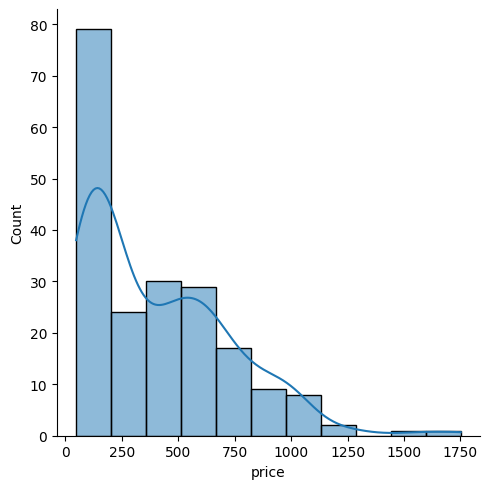

In [20]:
# Distribuția variabilei price înainte de logaritmare
sns.displot(x="price", data=airbnb_df, kde=True);

In [21]:
# Logaritmarea variabilelor

df_log = airbnb_df.copy()

df_log['price'] = np.log10(df_log['price'])
df_log.head()

,city,price,day,room_type,shared_room,private_room,person_capacity,superhost,multiple_rooms,business,cleanliness_rating,guest_satisfaction,bedrooms,city_center_km,metro_distance_km
0,Budapest,1.988871,Weekday,Entire home/apt,False,False,3,False,0,1,9,88,1,2.74,1.12
1,Rome,2.086360,Weekend,Entire home/apt,False,False,2,False,0,1,7,73,1,5.15,2.77
2,Athens,1.686636,Weekend,Entire home/apt,False,False,2,True,0,1,8,70,1,7.61,3.31
3,Paris,2.788324,Weekday,Entire home/apt,False,False,2,False,1,0,7,65,1,11.72,3.74
4,Amsterdam,3.194215,Weekend,Entire home/apt,False,False,2,False,0,1,10,100,1,2.41,0.05


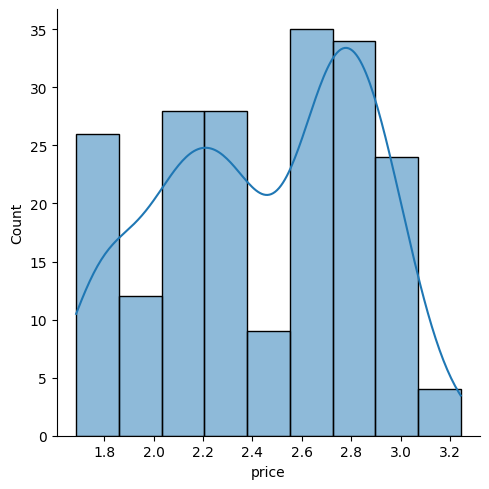

In [22]:
# Distribuția variabilei price după logaritmare

sns.displot(x="price", data=df_log, kde=True);

***Concluzie***

În continuare, variabila price va fi utilizată în forma ei inițială, dat fiind faptul că prin logaritmare variabila nu se apropie de forma distribuției normale, fiind chiar o distribuție bimodală ce nu facilitează implementarea metodelor statistice următoare.

<ipython-input-23-ab750180fb62>:3: UserWarning:

The palette list has more values (9) than needed (2), which may not be intended.



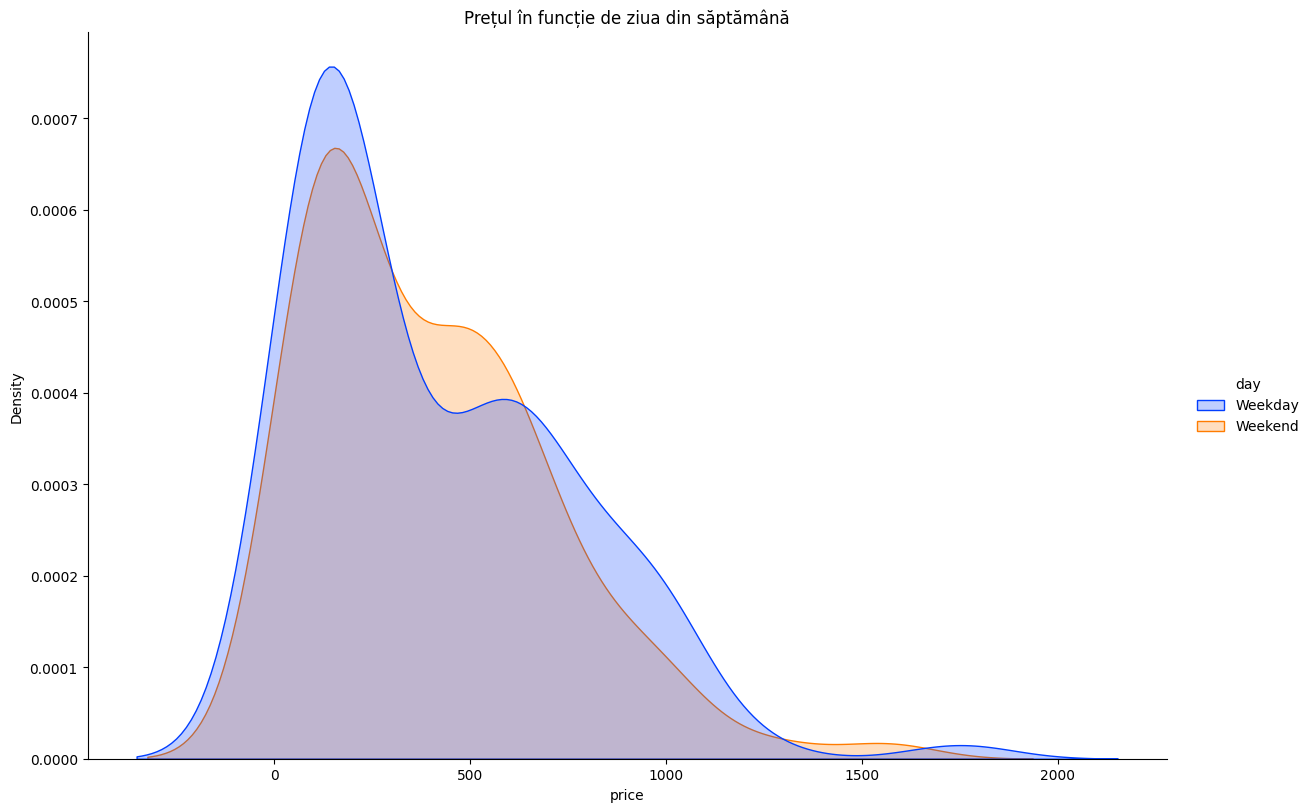

In [23]:
# Distribuția prețurilor apartamentelor în funcție de ziua din săptămână pentru care se face închirierea

sns.displot(data=airbnb_df,
            x='price',
            hue='day',
            kind='kde',
            fill=True,
            palette=sns.color_palette('bright')[:9],
            height=8,
            aspect=1.5).set(title='Prețul în funcție de ziua din săptămână')

***Interpretare***

Analizând graficul anterior, observăm că prețul apartamentelor Airbnb nu depinde semnificativ privind ziua pentru care se face închirierea. Adică, indiferent dacă se închiriază într-o zi din weekend sau într-o zi din timpul săptămânii lucrătoare, prețul este similar.

<ipython-input-24-927fe3c07cb6>:3: UserWarning:

The palette list has more values (9) than needed (5), which may not be intended.



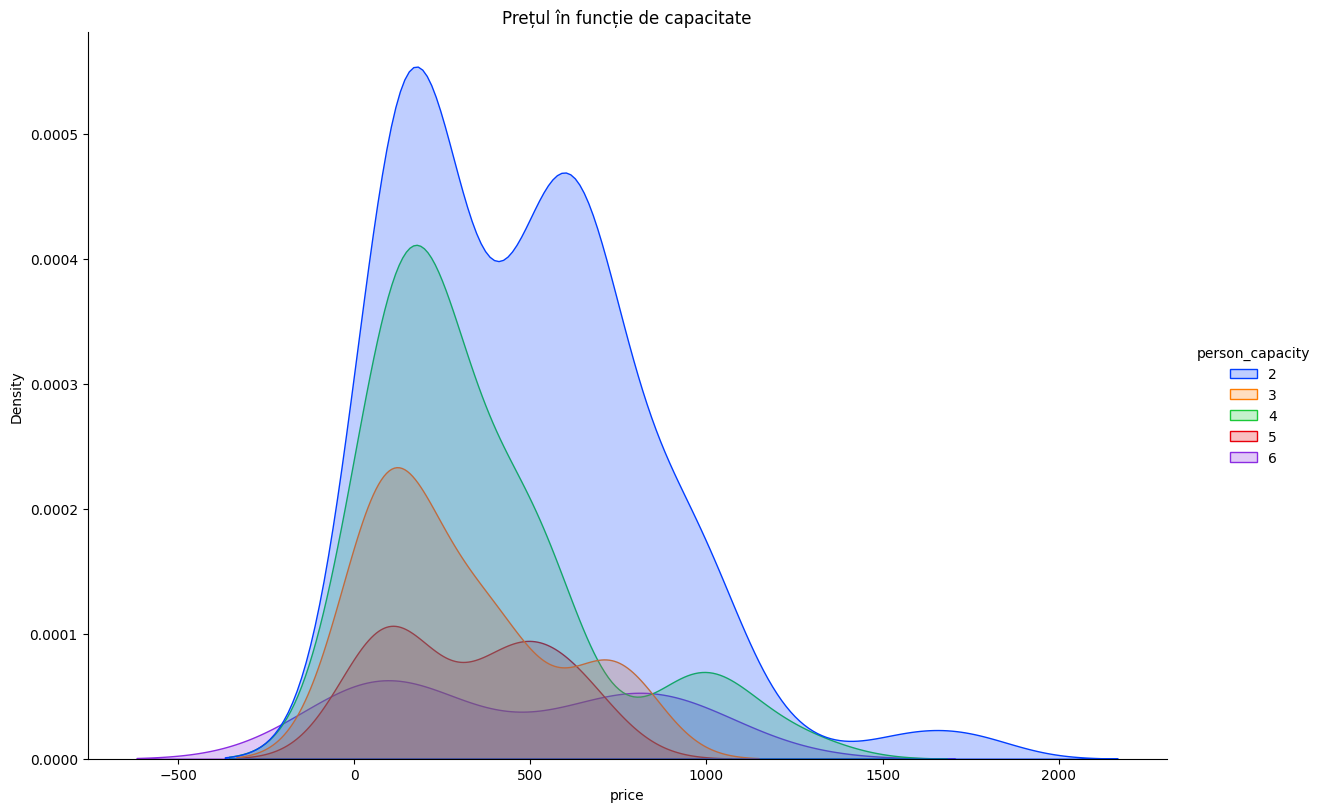

In [24]:
# Distribuția prețurilor apartamentelor Airbnb în funcție de capacitatea acestora

sns.displot(data=airbnb_df,
            x='price',
            hue='person_capacity',
            kind='kde',
            fill=True,
            palette=sns.color_palette('bright')[:9],
            height=8,
            aspect=1.5).set(title='Prețul în funcție de capacitate')

***Interpretare***

Analizând graficul anterior, se poate concluziona că:


*   Apartamentele cu capacitate pentru 2 persoane au o gamă mai largă de prețuri, comparativ cu restul, dar majoritatea prețurilor sunt concentrare în jurul intervalului de prețuri mai mici.
*   Pe măsură ce capacitatea locuințelor crește la 3 sau 4 persoane, vârful distribuției prețurilor se deplasează spre dreapta, indicând că aceste apartamente sunt mai scumpe.
*   Apartamentele cu o capacitate de 5 sau 6 persoane au o distirbuție mai îngustă, sugerând mai puțină variabilitate în ceea ce privește prețul.
*   Se remarcă o suprapunere semnificativă între distribuții, ceea ce indică prezența a mai multor factori ce influențează variabila preț și că există anumite similarități pentru stabilirea prețurilor.





---

Înainte de a trece la modelele statistice, important este să cunoaștem forma legăturilor între variabilele numerice pentru care se poate trasa diagrama de dispersie (Scatterplot), pentru a cunoaște dacă regresia liniară este sau nu o alegere bună de a analiza datele.



---






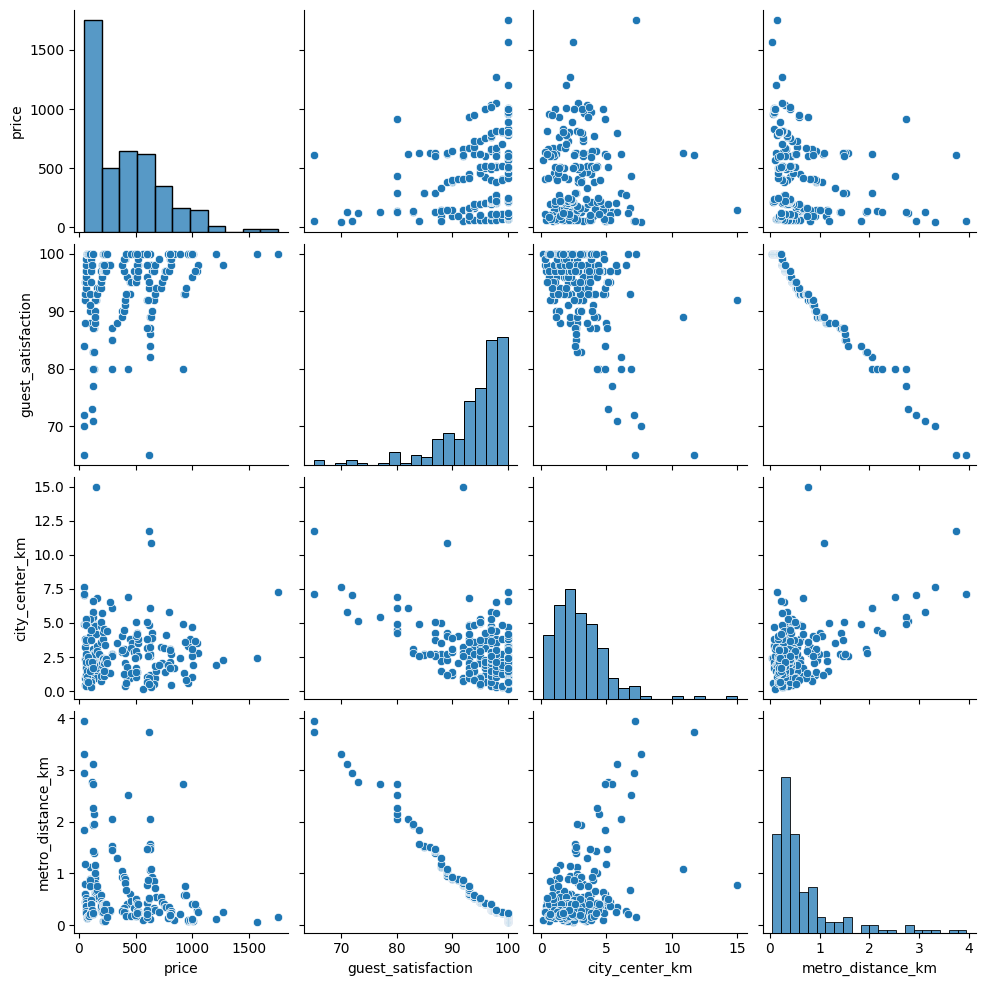

In [25]:
airbnb_df1 = airbnb_df[['price', 'guest_satisfaction', 'city_center_km', 'metro_distance_km']]
sns.pairplot(airbnb_df1);

## Modele de regresie liniară



---


În justificarea alegerii unui model de regresie liniară multifactorială, care să fie folosit pentru a previziona satisfacția clienților platformei Airbnb, a fost realizată o matrice de corelație între variabilele incluse în analiză, folosind culoarea pentru a marca intensitatea legăturii, grafic numit HeatMap.


---



<ipython-input-26-a9a4c10d8212>:6: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

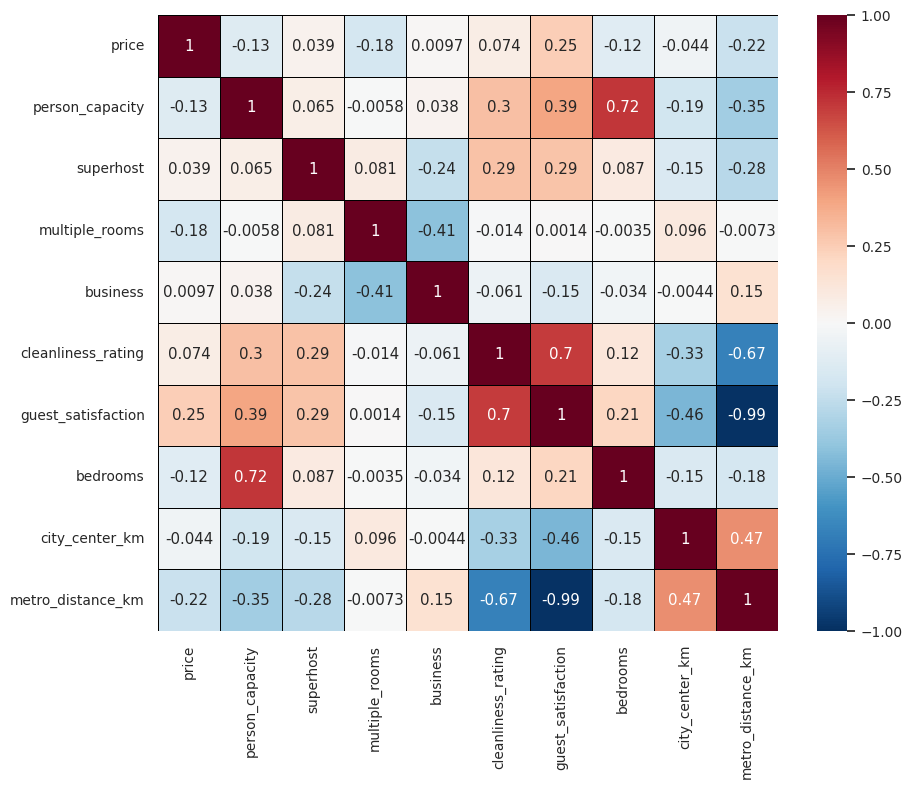

In [26]:
# Matricea de corelații - Heatmap

sns.set(font_scale=0.9)
plt.figure(figsize=(10,8))
sns.heatmap(
    airbnb_df.corr(),
    cmap='RdBu_r',
    annot=True,
    vmin=-1, vmax=1,
    linewidths=0.5,
    linecolor='black',
    square=False,
)

***INTERPRETARE***

Din analiza matricei de corelații, observăm că exsită legături puternice între variabilele de interes pe care le vom include în modelele de regresie, așadar, la o primă vedere, modelul de regresie liniară ar putea fi afectat de mutlicolinearitate între variabilele independente incluse în model. Există legături de intensitate:

*   **Slabă**: între preț și satisfacția clientului, numărul de dormitoare și satisfacția clientului
*   **Medie**: între capacitate și satisfacția clientului, satisfacția clientului și distanța dintre apartament și centrul orașului, numărul de km până în centrul orașului și numărul de km până la cea mai apropiată stație de metrou și multe altele
*   **Puternică**: între capacitate și număr de dormitoare, satisfacția clientului și distanța până la metrou, rata de curățenie și nivelul de satisfacție al clientului și multe altele
Plus încă alte legături de intensitate foarte slabă, ce nu depășesc pragul de 0,3.

Ținând cont de faptul că există variabile puternic corelate între ele, poate fi luată în considerare aplicarea unei metode de reducerere a dimensionalității spațiului printr-o metodă de Analiză în Componente Principale (ACP).





---


În continuare, am optat pentru transformarea variabilelor calitative din baza de date, în variabile numerice, pentru a putea fi utilizate în modelele de Machine Learning ce utilizează doar date numerice. A fost folosită codificarea de tip Label Encoder, pentru a minimiza numărul de variabile incluse în analiză.

*Prin metoda Label Encoder, fiecare categorie distinctă din variabilele categoriale primește un cod unic, numerotat de la valoarea 0.*


---



In [27]:
# Codificarea variabilelor categoriale folosind metoda Label Encoder

le = LabelEncoder()

le.fit(airbnb_df.city)
airbnb_df.city = le.transform(airbnb_df.city)

le.fit(airbnb_df.day)
airbnb_df.day = le.transform(airbnb_df.day)

le.fit(airbnb_df.room_type)
airbnb_df.room_type = le.transform(airbnb_df.room_type)

le.fit(airbnb_df.shared_room)
airbnb_df.shared_room = le.transform(airbnb_df.shared_room)

le.fit(airbnb_df.private_room)
airbnb_df.private_room = le.transform(airbnb_df.private_room)

le.fit(airbnb_df.superhost)
airbnb_df.superhost = le.transform(airbnb_df.superhost)

In [28]:
airbnb_df.dtypes

city                    int64
price                 float64
day                     int64
room_type               int64
shared_room             int64
private_room            int64
person_capacity         int64
superhost               int64
multiple_rooms          int64
business                int64
cleanliness_rating      int64
guest_satisfaction      int64
bedrooms                int64
city_center_km        float64
metro_distance_km     float64
dtype: object

In [64]:
# Coloanele numerice vor fi reținute separat într-un dataframe pentru a fi standardizate

scaler = StandardScaler()
coloane_numerice = airbnb_df[["city", "price", "person_capacity", 'cleanliness_rating', 'bedrooms', 'city_center_km', 'metro_distance_km', 'guest_satisfaction']]
coloane_numerice_standardizate = pd.DataFrame(scaler.fit_transform(coloane_numerice), columns=coloane_numerice.columns)

coloane_numerice_standardizate

,city,price,person_capacity,cleanliness_rating,bedrooms,city_center_km,metro_distance_km,guest_satisfaction
0,-0.221595,-0.949852,-0.109643,-0.866998,-0.460131,-0.117797,0.660078,-0.911430
1,0.965521,-0.874069,-0.892807,-3.781276,-0.460131,1.073524,3.040946,-3.176790
2,-1.408711,-1.100831,-0.892807,-2.324137,-0.460131,2.289562,3.820139,-3.629862
3,0.569816,0.646589,-0.892807,-3.781276,-0.460131,4.321234,4.440608,-4.384982
4,-1.804416,3.580580,-0.892807,0.590141,-0.460131,-0.280924,-0.883879,0.900858
...,...,...,...,...,...,...,...,...
195,-1.408711,-0.954301,2.239850,0.590141,2.508457,-0.750533,-0.638578,0.900858
196,-0.221595,-0.873081,1.456686,0.590141,1.024163,1.805124,-0.638578,0.900858
197,-0.221595,-0.863751,1.456686,0.590141,2.508457,-0.626951,-0.624148,0.900858
198,0.965521,0.331780,2.239850,0.590141,1.024163,0.589086,-0.624148,0.900858





---




## Regresia liniară



---





### Model de regresie liniară folosind biblioteca statsmodels - modelul OLS

  Am ales ca primă analiză estimarea unui model de regresie liniară construit cu ajutorul bibliotecii statsmodels, pentru a vizualiza cu ușurință un rezultat detaliat al modelului, prin afișarea valorilor pentru coeficienți, p-values, R Squared și teste statistice privind cele 7 ipoteze ale modelului de regresie liniară multifactorială, în mod special pentru diagnosticarea erorilor.



In [30]:
# Separarea variabilei dependente de variabilele independente

X = coloane_numerice_standardizate.drop(['guest_satisfaction', 'bedrooms'],axis=1)
Y = coloane_numerice_standardizate['guest_satisfaction']

In [31]:
# Se împarte în 80% training și 20% test

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=0)

In [32]:
# Crearea modelului de regresie liniară folosind Ordinary Least Squared (OLS)

X2 = sm.add_constant(X)
est = sm.OLS(Y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:     guest_satisfaction   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     1610.
Date:                Thu, 04 Jan 2024   Prob (F-statistic):          7.04e-162
Time:                        14:06:09   Log-Likelihood:                 109.48
No. Observations:                 200   AIC:                            -205.0
Df Residuals:                     193   BIC:                            -181.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               2.255e-16      0

***INTERPRETARE***



1.   Modelul de regresie este **semnificativ statistic** pentru un prag de semnificație alpha=0.05, deoarece Prob (F-statistic) are o valoare mai mică decât 0.05. Garantăm cu o probabilitate de 95% că modelul de regresie este semnificativ statistic.
2.   Coeficientul de determinație **R Squared** arată că 98% din variabilitatea variabilei dependente ***guest_satisfaction*** este explicată de variabilitatea variabilelor independente incluse în model, restul de 2% fiind explicat de alte variabile, numite reziduuri. Putem concluziona că modelul are o calitate bună.
3.   Garantând rezultatele cu o probabilitate de 95%, variabilele ***price, person_capacity, cleanliness_rating și metro_distance_km*** influențează semnificativ variabila dependentă guest_satisfaction.
4.   Observând statistica testului Durbin-Watson, erorile modelului prezintă ***autocorelație pozitivă***, așadar ipoteza privind non-autocorelarea erorilor nu este respectată.
5.   Ipoteza privind ***normalitatea erorilor*** este nerespectată, dat fiind faptul că probabilitatea testului statistic Jarque-Bera nu depășește pragul de semnificație de 0.05, așadar vom respinge ipoteza nulă conform căreia erorile provin dintr-o distribuție normală, în favoarea ipotezei aleatoare.
6.  Pentru un nivel de semnificație de 95%, variabila city_center_km, privind distanța până în centrul orașului nu este semnificativă statistic, dat fiind valoarea p-value ce nu depășește pragul de semnificație de 0.05. Motivul pentru care această variabilă nu este semnificativă este preferința clienților de a nu pune accentul pe distanța până în centrul orașului, atâta timp cât există în apropiere o stație de metrou care facilitează sosirea în centrul orașului.
7. Interpretarea coeficienților:


*  ***price***: la creșterea cu o unitate standard a prețului, satisfacția clientului crește, în medie, cu 0,05 unități standard, restul variabilelor independente rămânând constante.
*  ***person_capacity***: la creșterea cu o unitate standard a capacității de persoane pentru apartament, satisfacția clientului crește, în medie, cu 0,07 unități standard, restul variabilelor independente rămânând constante.
*  ***cleanliness_rating***: la creșterea cu o unitate standard a ratei de curățenie, satisfacția clientului crește, în medie, cu 0,06 unități standard, restul variabilelor independente rămânând constante.
*  ***metro_distance_km***: la creșterea cu o unitate standard a distanței în km până la stația de metrou, satisfacția clientului scade, în medie, cu 0,91 unități standard, restul variabilelor independente rămânând constante.




### Model de regresie liniară folosind biblioteca scikit-learn și numpy pentru calcule matematice

Cea de-a doua abordare a dezvoltării unui model de regresie liniară multifactorială este prin:

*   crearea și antrenarea unui model de regresie liniară folosind biblioteca scikit-learn
*   definirea unor funcții prin care calculează metrici de evaluare a performanței modelului Mean Absolute Error, Mean Squared Error, RMSE, R Squared
*   calculul metricilor pe eșantionul de antrenare și testare, folosind aceste funcții
*   calcului statisticilor testului Student privind semnificația statistică a coeficienților pentru variabilele independente incluse în modelul de regresie, și implicit p-value asociate acestora
*   calculul statisticii Durbin Watson privind non-autocorelarea erorilor

***Scikit-learn*** folosește Metoda Celor mai Mici Pătrate (OLS) pentru a estima parametrii modelului. Aceasta se bazează pe minimizarea sumei pătratelor diferențelor dintre variabila dependentă și cele prezise de funcția liniară.
Cu alte cuvinte, încearcă să minimizeze suma patratelor erorilor (SSE) sau eroarea pătrată medie (MSE) dintre variabila target (y) și rezultatul previzionat (𝑦̂)


In [33]:
# Definirea funcțiilor pentru calculul metricilor de evaluare a performanței unui model

def cross_val(model):
    pred = cross_val_score(model, X, y, cv=10)
    return pred.mean()

def print_evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')

def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [34]:
# Crearea unei "măști" cu valori True și False pentru a împărți setul de date în 80% set de antrenare și 20% set de testare

msk = np.random.rand(len(airbnb_df)) < 0.8
msk

array([ True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True, False,  True,  True, False,
       False,  True,  True,  True, False,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True, False,  True, False,  True,  True,
        True,  True, False, False,  True,  True,  True, False,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True, False,  True, False,  True,  True, False,  True,  True,
        True, False,  True,  True, False, False,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,

In [35]:
# Împărțirea setului folosind masca creeată

train = coloane_numerice_standardizate[msk]
test = coloane_numerice_standardizate[~msk]

In [36]:
len(train)

159

In [37]:
len(test)

41

In [38]:
# Estimarea coeficienților pentru variabilele independente incluse în modelul de regresie

X_train = np.asanyarray(train[["city", "price", "person_capacity", 'cleanliness_rating', 'bedrooms', 'city_center_km', 'metro_distance_km']])
y_train = np.asanyarray(train[['guest_satisfaction']])

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

# Afișarea coeficientilor
print('Coefficientii estimati: ', regr.coef_)

Coefficientii estimati:  [[ 0.01296306  0.05628727  0.0538029   0.06862379  0.01879599  0.01921926
  -0.92330956]]


In [39]:
# Afișarea evaluării pentru setul de antrenare

train_pred = regr.predict(X_train)
print('Train set evaluation:\n_____________________________________')
print_evaluate(train['guest_satisfaction'], train_pred)

# Afișarea evaluării pentru setul de test

X_test = np.asanyarray(test[["city", "price", "person_capacity", 'cleanliness_rating', 'bedrooms','city_center_km', 'metro_distance_km']])
test_pred = regr.predict(X_test)
print('\nTest set evaluation:\n_____________________________________')
print_evaluate(test['guest_satisfaction'], test_pred)

# Adăugarea rezultatelor în DataFrame-ul principal
results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(test['guest_satisfaction'], test_pred)]],
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square'])

Train set evaluation:
_____________________________________
MAE: 0.11319086134003027
MSE: 0.01958179010842599
RMSE: 0.1399349495602367
R2 Square 0.9820287513473281
__________________________________

Test set evaluation:
_____________________________________
MAE: 0.1130405845583563
MSE: 0.021734689119107975
RMSE: 0.14742689415133176
R2 Square 0.9666858683248675
__________________________________


***INTERPRETARE***

 **MAE (Eroarea Medie Absolută):** este media valorii absolute a erorilor.
Aceasta este cea mai ușor de înțeles dintre valori, deoarece este doar o eroare medie.

**MSE (Media Pătratelor Erorilor):**  este media erorilor pătratice.
Este mai populara decât Eroarea absolută medie, deoarece accentul este orientat mai mult către erori mari.
Acest lucru se datorează faptului că termenul pătrat crește exponențial erorile mai mari în comparație cu cele mai mici.

**Root Mean Squared Error (RMSE).** Este radicalul mediei patratului erorilor.

**R-pătrat** nu este o eroare, ci mai degrabă o măsură populară pentru a măsura performanța modelului de regresie.
Reprezintă cât de aproape sunt punctele observate de linia de regresie ajustată.
Cu cât valoarea lui R pătrat este mai mare, cu atât modelul se potrivește mai bine cu datele dvs.

Comparând rezultatele obținute pe setul de testare, cu cele obținute pe setul de antrenare, modelul reușește să previzioneze bine datele din setul de testare, folosind pentru antrenare 80% din setul inițial de date. Date fiind valorile apropiate de 1 pentru R Squared în cazul ambelor eșantioane, modelul nu suferă de fenomenul de overfitting sau underfitting, având o performanță bună.

In [40]:
# Calculul statisticilor t ale testului Student și p-value pentru coeficienții de regresie

# Coeficienți de regresie
coef = regr.coef_

# Intercept-ul
intercept = regr.intercept_

# Numărul de eșantioane
n = len(y_train)

# Numărul de variabile independente
p = 7

# Calculul eroareii standard a estimatorului coeficientului de regresie
stderr = np.sqrt(((y_train - regr.predict(X_train)) ** 2).sum() / (n - p - 1))

# Calcul statistici t
t_statistic = coef / (stderr / np.sqrt(((X_train - X_train.mean()) ** 2).sum()))

# Calculează valorile p pentru testele t
p_value = 2 * (1 - stats.t.cdf(np.abs(t_statistic), df=n-p-1))

# Lista cu numele variabilelor
variable_names = ["city", "price", "person_capacity", 'cleanliness_rating', 'bedrooms', 'city_center_km', 'metro_distance_km']

# Afișarea rezultatelor pentru fiecare variabilă independentă
print('\nStatistici t și p-value pentru fiecare coeficient:\n')
for variable, coefficient, t_stat, p_val in zip(variable_names, coef[0], t_statistic[0], p_value[0]):
    print(f'{variable}: Coeficient: {coefficient:.4f} | T-statistic: {t_stat:.4f} | P-value: {p_val:.4f}')





Statistici t și p-value pentru fiecare coeficient:

city: Coeficient: 0.0130 | T-statistic: 2.9906 | P-value: 0.0033
price: Coeficient: 0.0563 | T-statistic: 12.9855 | P-value: 0.0000
person_capacity: Coeficient: 0.0538 | T-statistic: 12.4124 | P-value: 0.0000
cleanliness_rating: Coeficient: 0.0686 | T-statistic: 15.8316 | P-value: 0.0000
bedrooms: Coeficient: 0.0188 | T-statistic: 4.3363 | P-value: 0.0000
city_center_km: Coeficient: 0.0192 | T-statistic: 4.4339 | P-value: 0.0000
metro_distance_km: Coeficient: -0.9233 | T-statistic: -213.0087 | P-value: 0.0000


***INTERPRETARE***


Toți coeficientii sunt semnificativi pentru un nivel de semnificație de 0.01, cu excepția variabilei privind distanța până în centrul orașului, măsurată în km.


Coeficientul corespunzator variabilei metro_distance_km este negativ ceea ce înseamnă că această variabilă este invers corelată cu satisfacția clientului.
Prețul, capacitatea, rata de curățenie și numărul de dormitoare, influențează în mod direct satisfacția clienților Airbnb.

 Interpretarea coeficineților:

*  ***city***: la creșterea cu o unitate standard a variabilei city, satisfacția clientului crește, în medie, cu 0,02 unități standard, restul variabilelor independente rămânând constante
*  ***price***: la creșterea cu o unitate standard a prețului, satisfacția clientului crește, în medie, cu 0,05 unități standard, restul variabilelor independente rămânând constante.
*  ***person_capacity***: la creșterea cu o unitate standard a capacității de persoane pentru apartament, satisfacția clientului crește, în medie, cu 0,06 unități standard, restul variabilelor independente rămânând constante.
*  ***cleanliness_rating***: la creșterea cu o unitate standard a ratei de curățenie, satisfacția clientului crește, în medie, cu 0,05 unități standard, restul variabilelor independente rămânând constante.
*  ***city_center_km***: la creșterea cu o unitate standard a distanței până în centrul orașului, satisfacția clientului crește, în medie, cu 0,002 unități standard, restul variabilelor independente rămânând constante.
*  ***metro_distance_km***: la creșterea cu o unitate standard a distanței în km până la stația de metrou, satisfacția clientului scade, în medie, cu 0,91 unități standard, restul variabilelor independente rămânând constante.

**Calculul statisticii Durbin Whatson**

In [41]:
# Obținerea reziduurilor pentru model
train_residuals = y_train - train_pred

# Calcul statistici Durbin-Watson pentru eșantionul de training
dw_statistic_train = np.sum(np.diff(train_residuals, axis=0) ** 2) / np.sum(train_residuals ** 2)

# Număr de observații pentru eșantionul de training
n_train = len(y_train)

# Număr de variabile independente pentru eșantionul de training
k_train = X_train.shape[1]

# Calcul intervale valori critice pentru testul Durbin-Watson
d1_train, d2_train = 2.0, 2.0
for i in range(k_train):
    d1_train += 2 * (k_train - i)
    d2_train += 2 * (n_train - k_train - i)

# Determinarea tipului de autocorelație pentru eșantionul de training
if dw_statistic_train < d1_train:
    result_train = "Autocorelație pozitivă"
elif dw_statistic_train > d2_train:
    result_train = "Autocorelație negativă"
else:
    result_train = "Non-autocorelație"

print("Durbin-Watson Statistic (Training Set):", dw_statistic_train)
print("Result (Training Set):", result_train)


Durbin-Watson Statistic (Training Set): 1.2169967985058416
Result (Training Set): Autocorelație pozitivă


***INTERPRETARE***

Valoarea statisticii testului Durbin Watson de 1,2 conduce la concluzia că erorile modelului statistic sunt autocorelate pozitiv, așadar pentru ca modelul să poată fi folosit pentru previziune, reziduurile ar trebui revizuite.

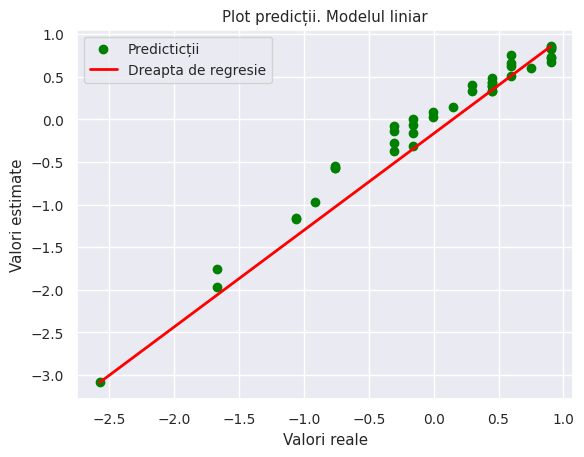

In [42]:
# Afișarea predicțiilor pe setul de test
plt.scatter(test['guest_satisfaction'], test_pred, color='green', label='Predicticții')
plt.plot([min(test['guest_satisfaction']), max(test['guest_satisfaction'])],
         [min(test_pred), max(test_pred)], color='red', linewidth=2, label='Dreapta de regresie')
plt.title('Plot predicții. Modelul liniar')
plt.xlabel('Valori reale')
plt.ylabel('Valori estimate')
plt.legend()
plt.show()


***INTERPRETARE***

Se observă că valorile estimate cu ajutorul modelului sunt apropiate de cele reale, toate valorile concentrându-se în jurul dreptei de regresie, așadar putem concluziona că modelul liniar se potrivește setului de date

<Figure size 800x600 with 0 Axes>

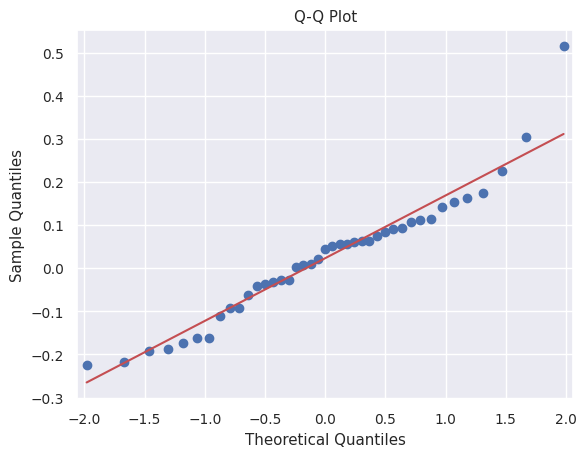

In [43]:
# Q-Q Plot

# Obținerea reziduurilor pentru modelul de regresie liniară pe setul de test
test_residuals = test['guest_satisfaction'] - test_pred.flatten()

plt.figure(figsize=(8, 6))
sm.qqplot(test_residuals, line='s')
plt.title("Q-Q Plot")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.show()


***INTERPRETARE***

Din Q-Q Plot se observă că reziduurile modelului de regresie liniară urmează o distribuție aproximativ normală. Observațiile sunt foarte apropiate de linia roșie, cu mici excepții în capete care sunt considerate abateri, indicând ușoare devieri de la normalitate (numindu-se că au "cozi grele" - heavy tailed, care indică posibila prezență a valorilor aberante)

In [44]:
# Salvarea în csv a valorilor pentru guest satisfaction versus predicții făcute de model

estimari = pd.DataFrame({
    'guest_satisfaction': test['guest_satisfaction'],
    'Predictions': test_pred.flatten()
})

estimari.to_csv('estimari_regresie.csv', index=False)
estimari.head(8)

,guest_satisfaction,Predictions
7,-2.572694,-3.087541
14,-1.666550,-1.757999
17,0.598810,0.760410
18,-1.666550,-1.971882
22,-1.062454,-1.154973
26,-0.760406,-0.543343
36,-0.307334,-0.082050
40,-0.307334,-0.368873


### Model de regresie folosind Extreme Gradient Boosting (XGBoost)

XGBoost este un algoritm de învățare automată bazat pe tehnica de îmbunătățire a modelelor de tip ensemble. Esența acestei tehnici constă în construirea și agregarea mai multor modele de bază slabe pentru a obține un model final robust și precis.

XGBoost este o implementare specifică a metodelor de boosting, care optimizează procesul de îmbunătățire prin utilizarea unor tehnici inovatoare precum regularizare.

Boosting-ul este o metodă de îmbunătățire a performanței unui model prin antrenarea secvențială a unor modele slabe, unde fiecare model ulterior se concentrează pe corectarea erorilor făcute de modelele anterioare.

XGBoost introduce doi termeni de regularizare, L1 și L2 (numiți și regularizare LASSO și Ridge), care sunt adăugați la funcția de cost pentru a preveni supraantrenarea și pentru a îmbunătăți generalizarea modelului. Acești termeni de regularizare sunt controlați prin parametri precum alpha și lambda.

XGBoost optimizează funcția de cost asociată cu eroarea pătrată medie (MSE) între predicțiile modelului și valorile reale ale variabilei țintă.

XGBoost furnizează o măsură a importanței caracteristicilor. Dacă două variabile sunt puternic corelate, modelul poate alege să pună mai mult accent pe una dintre ele, ceea ce poate fi observat prin importanța caracteristicilor, ceea ce reprezintă o rezolvare în problema multicolinearității între variabile.

Compatibilitate cu Seturi de Date Heterogene:
XGBoost poate lucra cu seturi de date care conțin atât caracteristici numerice, cât și categorice, fără a necesita preprocesare specială.


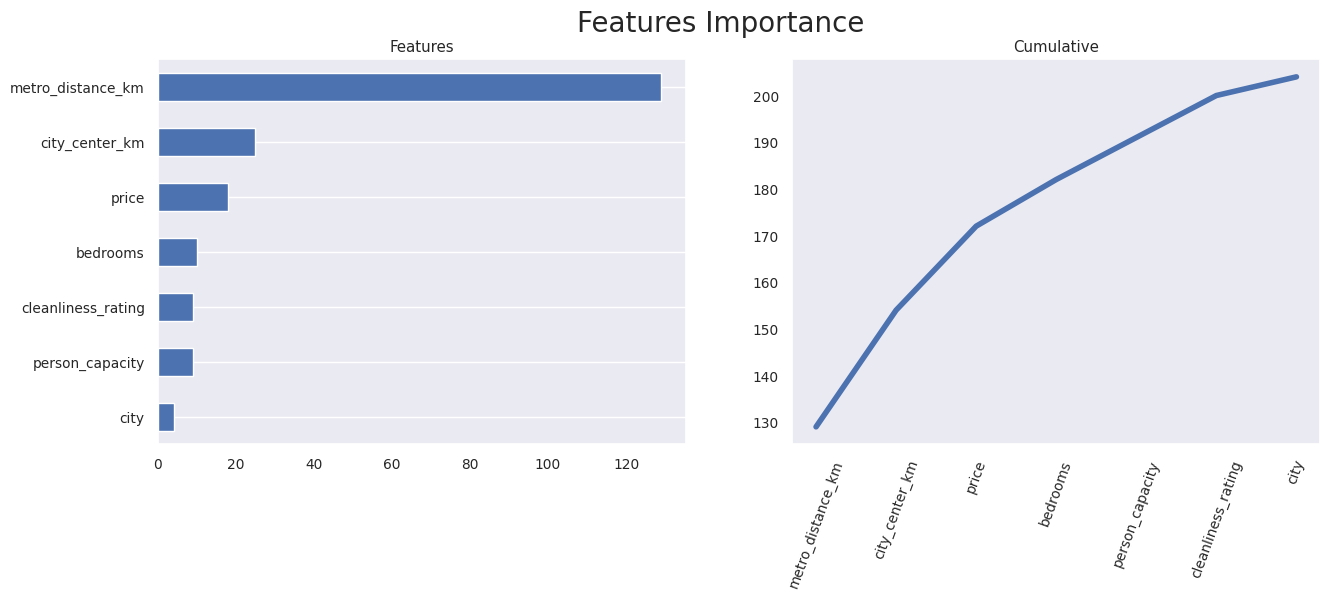

In [45]:
# Împărțirea setului de date în caracteristici (X) și variabila țintă (y)
X = coloane_numerice_standardizate.drop('guest_satisfaction', axis=1)
y = coloane_numerice_standardizate['guest_satisfaction']

# Împărțirea setului de date în seturi de antrenament și de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Transformarea datelor într-un format specific XGBoost, includerea numelor caracteristicelor
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist())

# Definirea parametrilor modelului XGBoost
params = {
    'objective': 'reg:squarederror',  # pentru regresie
    'eval_metric': 'rmse',  # sau 'mae', 'mse', 'r2' etc.
    'max_depth': 3,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'alpha': 10,
    'lambda': 5,
    'seed': 42
}

# Antrenarea modelului
num_round = 100  # Numărul de runde de antrenament (poate fi ajustat)
bst = xgb.train(params, dtrain, num_round)

# Afișarea importanței caracteristicelor
importances = bst.get_score(importance_type='weight')
importances = {feature: importance for feature, importance in sorted(importances.items(), key=lambda x: x[1], reverse=True)}
dtf_importances = pd.DataFrame(list(importances.items()), columns=['VARIABLE', 'IMPORTANCE'])
dtf_importances['cumsum'] = dtf_importances['IMPORTANCE'].cumsum(axis=0)
dtf_importances = dtf_importances.set_index("VARIABLE")

# Plot
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(15, 5))
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('Features')
dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(
    kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('Cumulative')
dtf_importances[["cumsum"]].plot(kind="line", linewidth=4,
                                 legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dtf_importances)),
          xticklabels=dtf_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')
plt.show()


***INTERPRETARE***



*   Caracteristicile care au cea mai mare importanță în crearea modelului de XGBoost sunt distanța în km până la metrou, urmat de variabila privind distanța până în centrul orașului, preț, si toate celelalte variabile incluse în model
*   Din graficul Cumulative se observă importanța cumulată a caracteristicilor pe măsură ce fiecare variabilă este adăugată, în ordinea importanței sale individuale. Se observă că primele 3 caracteristici aduc cea mai mare proporție de informații, mai exact 150 din totalul de 200 de puncte de importanță a caracteristicilor.





In [46]:
# Inițializare model XGBoost Regressor
xgb_reg = XGBRegressor(n_iter_no_change=250, eta0=0.0001, max_iter=10000)

# Antrenarea modelului pe setul de antrenament
xgb_reg.fit(X_train, y_train)

# Realizarea predicțiilor pe setul de test și antrenament
test_pred = xgb_reg.predict(X_test)
train_pred = xgb_reg.predict(X_train)

# Evaluarea performanței modelului
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

# Adăugare rezultate în DataFrame
results_df_temp = pd.DataFrame(data=[["XGBoost", *evaluate(y_test, test_pred)]],
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square'])
results_df = results_df.append(results_df_temp, ignore_index=True)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[14:06:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eta0", "max_iter", "n_iter_no_change" } are not used.




Test set evaluation:
_____________________________________
MAE: 0.020504789495115028
MSE: 0.0019598346675912147
RMSE: 0.04427001996375442
R2 Square 0.9976050017363788
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.0005264264001437499
MSE: 6.594095557273814e-07
RMSE: 0.0008120403658238804
R2 Square 0.9999993690949046
__________________________________


<ipython-input-46-25feb0ce2208>:22: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



***INTERPRETARE***

Analizând rezultatele metricilor pentru seturile de test și de antrenament, modelul XGBoost se comportă excelent pe setul de test, ținând cont de metrici precum MAE, MSE și R2 Square care indică o performanță foarte bună în predicția variabilei țintă, guest_satisfaction. Pentru ambele seturi de date, valoarea pentru R Squared se apropie de valoarea maximă de 1.

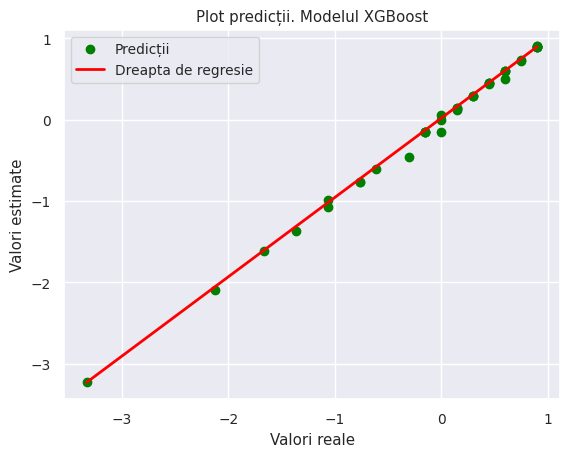

In [47]:
import matplotlib.pyplot as plt

# Afișarea predicțiilor pe setul de test pentru XGBoost
plt.scatter(y_test, test_pred, color='green', label='Predicții')
plt.plot([min(y_test), max(y_test)], [min(test_pred), max(test_pred)], color='red', linewidth=2, label='Dreapta de regresie')
plt.title('Plot predicții. Modelul XGBoost')
plt.xlabel('Valori reale')
plt.ylabel('Valori estimate')
plt.legend()
plt.show()


***INTERPRETARE***

De această dată valorile estimate sunt și mai apropiate de cele reale, comparativ cu modelul liniar. Se observă că valorile sunt în acest caz mai apropiate de dreapta de regresie, așadar putem concluziona că cel mai bun model în previzionarea satisfacției clienților privind alegerea locuinței este modelul Extreme Gradient Boosting.

In [48]:
# Salvarea în csv a valorilor pentru guest satisfaction versus predicții făcute de model

estimari_xgb = pd.DataFrame({
    'guest_satisfaction': y_test,
    'Predictions': test_pred.flatten()
})

estimari_xgb.to_csv('estimari_xgb.csv', index=False)
estimari_xgb.head(8)

,guest_satisfaction,Predictions
95,0.145738,0.137863
15,-3.327814,-3.229726
30,-1.062454,-1.070744
158,0.598810,0.597385
128,-1.062454,-0.990402
115,0.900858,0.901374
69,-0.760406,-0.759364
170,0.447786,0.451029


Compararea performanței modelelor

In [49]:
results_df.reset_index()

,index,Model,MAE,MSE,RMSE,R2 Square
0,0,Linear Regression,0.113041,0.021735,0.147427,0.966686
1,1,XGBoost,0.020505,0.001960,0.044270,0.997605


Text(0.5, 1.0, 'Comparație între modele')

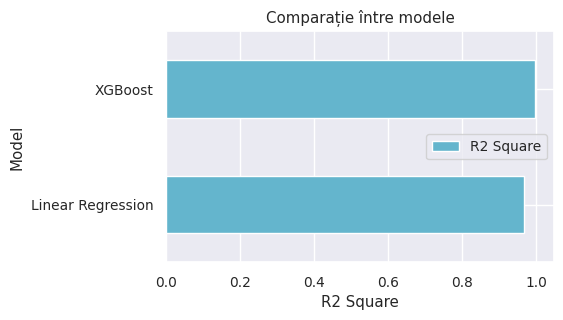

In [50]:
# Reprezentare grafică

results_df.plot(kind='barh', x='Model', y='R2 Square', figsize=(5, 3), color='c')
plt.xlabel('R2 Square')
plt.ylabel('Model')
plt.title('Comparație între modele')

***INTERPRETARE***

Modelul XGBoost are o performanță mai mare, comparativ cu modelul de regresie liniară, însă diferența nu este foarte mare. Ambele modele au o calitate foarte bună pentru acest set de date, în ceea ce privește valoarea coeficientului de determinație R Squared.




---




## Analiza de clusterizare



---





### Metoda Ward - metodă ierarhică

Algoritmul ierarhic a fost aplicat în primă fază pentru a vedea numărul optim de clustere în care se pot împărți observațiile, lucru vizibil din dendogramă.

In [51]:
# Pregătirea dataframe-ului și standardizarea variabilelor

airbnb_df_ = airbnb_df.drop(["day", "private_room", "room_type","shared_room", "private_room", "superhost", "multiple_rooms", "business"], axis=1)

Clus_dataSet = StandardScaler().fit_transform(airbnb_df_)

Clus_dataSet

array([[-0.22159501, -0.94985216, -0.10964301, ..., -0.46013112,
        -0.11779747,  0.66007765],
       [ 0.9655211 , -0.87406949, -0.89280737, ..., -0.46013112,
         1.07352396,  3.04094576],
       [-1.40871111, -1.10083051, -0.89280737, ..., -0.46013112,
         2.2895616 ,  3.82013896],
       ...,
       [-0.22159501, -0.86375094,  1.45668571, ...,  2.50845673,
        -0.62695144, -0.62414818],
       [ 0.9655211 ,  0.3317801 ,  2.23985008, ...,  1.02416281,
         0.5890862 , -0.62414818],
       [-1.01300574,  0.65940961, -0.89280737, ..., -0.46013112,
        -1.23002702, -0.20569258]])

In [52]:
# Aplicarea metodei Ward pentru clusterizare ierarhică

ward_clusters = AgglomerativeClustering(n_clusters=3, linkage='ward')
ward_clusters.fit(Clus_dataSet)

AgglomerativeClustering(n_clusters=3)

In [53]:
# Etichetele fiecărei observații din setul de date

labels = ward_clusters.fit_predict(Clus_dataSet)
labels

array([0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 2, 0, 1, 0, 1, 2, 2, 0, 0, 1, 1, 1, 0, 0, 1,
       2, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1,
       2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2,
       2, 1])

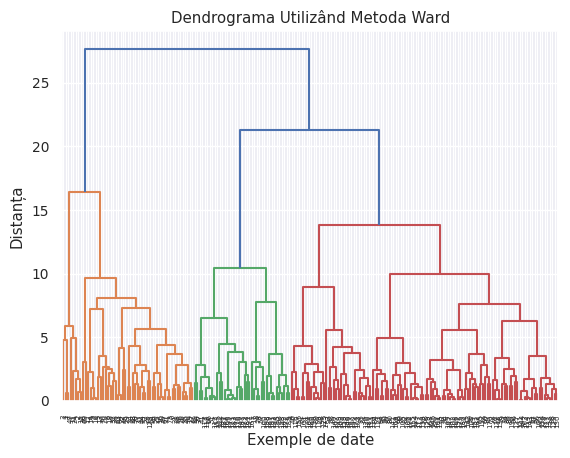

In [54]:
# Vizualizarea rezultatelor prin dendrogramă

linkage_matrix = linkage(Clus_dataSet, 'ward')
dendrogram(linkage_matrix)

plt.title('Dendrograma utilizând metoda Ward')
plt.xlabel('Exemple de date')
plt.ylabel('Distanța')
plt.show()

***INTERPRETARE***

Se alege partiția care corespunde diferenței maxime de distanță, adică acolo unde există cea mai mare pierdere de inerție. Din dendograma prezentată mai sus, se observă că cea mai mare pierdere de inerție dintre clase este pentru K=3.


## **K-Means Clustering**

Abordarea algoritmului este următoarea:



*   Standardizarea datelor pentru a avea aceeași unitate de măsură a datelor
*   Aplicarea metodei Elbow pentru alegerea numărului optim de clustere. Această metodă trebuie aplicată, dat fiind faptul că algoritmul KMeans este un algoritm de învățare nesupervizată. Metoda va calcula inerția intra-clustere pentru un număr de până la 20 de clustere, iar numărul optim de clustere va fi identificat la "cotitura" graficului, adică acolo unde se pierde cel mai mult din inerție.
*   Aplicarea algoritmului KMeans pentru numărul de clustere identificat în etapa anterioară, ținând cont și de rezultatele obținute prin algoritmul Ward
*   Identificarea fiecărei observații din ce cluster face parte
*   Calcularea centrelor de greutate care caracterizează fiecare cluster, prin calcularea valorilor medii la nivel de cluster pentru fiecare variabilă analizată și salvarea rezultatelor într-un fișier .csv
*   Verificarea omogenității în clustere, prin numărarea observațiilor înregistrate în fiecare cluster
*   Reprezentarea grafică a clusterelor, fiind diferențiate prin culoare și asocierea etichetelor privind orașul corespunzător
*   Trasarea histogramelor pentru fiecare cluster, privind nivelul de satisfacție al clienților





/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

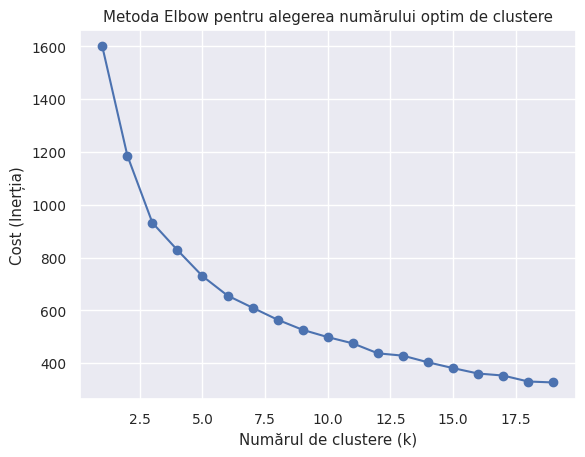

In [55]:
# Lista pentru a stoca costurile
costs = []

# Încercăm valori alese pentru k între 1 și 20
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(Clus_dataSet)
    # Inertia_ reprezintă costul
    costs.append(kmeans.inertia_)

# Se trasează graficul pentru a evalua metoda cotului (Elbow method)
plt.plot(range(1, 20), costs, marker='o')
plt.xlabel('Numărul de clustere (k)')
plt.ylabel('Cost (Inerția)')
plt.title('Metoda Elbow pentru alegerea numărului optim de clustere')
plt.show()

***INTERPRETARE***

Cea mai bruscă scădere din graficul Elbow se observă la aproximativ 3 clustere, așadar în analiză au fost păstrate 3 clustere, considerând că este numărul optim în care grupele conțin observații foarte asemănătoare, și grupe foarte diferite între ele. Acest lucru era observabil și din analiza dendogramei.

In [56]:
# Algoritmul K-Means aplicat pentru 3 clustere

k_means = KMeans(init = "k-means++", n_clusters = 3, n_init = 12)
k_means.fit(Clus_dataSet)
labels = k_means.labels_
print(labels)

[0 1 1 1 0 1 1 1 2 1 1 1 1 1 1 1 0 2 1 1 1 0 1 0 1 0 0 0 0 1 0 0 1 1 1 0 1
 2 1 2 0 2 1 0 0 0 0 0 0 1 0 2 0 0 0 0 2 2 0 0 2 0 0 2 2 0 2 0 0 1 1 0 0 0
 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0 2 2 2 0 0 0 0
 0 2 0 0 0 0 2 2 0 0 0 2 0 0 0 0 0 1 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 2 0 0 0 0 2 0 2 0 2 0 0 0 2 2 0 0 2 2 2 0 0 0 2 0 0 2 0 2 2 2 2
 2 0 2 2 2 0 2 0 2 2 2 2 2 2 0]


In [57]:
# Afișarea label-urilor privind cluster-ul din care face parte fiecare observație din setul de date inițial

airbnb_df_["Cluster"] = labels
airbnb_df_.to_csv("cluster_labels.csv")
airbnb_df_.head()

,city,price,person_capacity,cleanliness_rating,guest_satisfaction,bedrooms,city_center_km,metro_distance_km,Cluster
0,4,97.47,3,9,88,1,2.74,1.12,0
1,7,122.00,2,7,73,1,5.15,2.77,1
2,1,48.60,2,8,70,1,7.61,3.31,1
3,6,614.22,2,7,65,1,11.72,3.74,1
4,0,1563.92,2,10,100,1,2.41,0.05,0


In [58]:
#Afișarea centrelor de greutate

cluster_mean = airbnb_df_.groupby('Cluster').mean()
cluster_mean.to_csv('Cluster_mean.csv')
cluster_mean

,city,price,person_capacity,cleanliness_rating,guest_satisfaction,bedrooms,city_center_km,metro_distance_km
Cluster,,,,,,,,
0,5.223140,448.245372,2.685950,9.735537,95.661157,0.983471,2.597521,0.464628
1,4.862069,310.027586,2.206897,8.551724,81.517241,1.068966,5.502414,2.023103
2,2.780000,355.136200,4.780000,9.860000,97.360000,2.240000,2.435800,0.352400


***INTERPRETARE***

*   **Clusterul 0**: conține orașele ***Budapesta*** și ***Atena***, adică preponderent orașe în care apartamentele sunt foarte ieftine, au o capacitate de aproximativ 2 persoane, au o rată a curațeniei foarte scăzută, comparativ cu celelalte clustere, clienții nu sunt foarte satisfăcuți, au doar un dormitor, se află foarte departe de centrul orașului și foarte departe de o stație de metrou.
*   **Clusterul 1**: conține orașele ***Paris*** și ***Amsterdam***, adică preponderent orașe în care apartamentele sunt foarte scumpe, au o capacitate de aproximativ 3 persoane, au o rată a curațeniei medie, clienții au un nivel mediu de satisfacție, au doar un dormitor sau niciunul, se află la o distanță medie de centrul orașului și sunt aproape de o stație de metrou.
*   **Clusterul 2**: conține orașele ***Roma*** și ***Viena***, adică preponderent orașe în care apartamentele nu sunt nici foarte scumpe, nici foarte ieftine, au o capacitate de aproximativ 5 persoane, sunt apartamente foarte curate, de care clienții sunt foarte satisfăcuți, au 2 dormitoare, se află foarte aproape de centrul orașului și foarte aproape de o stație de metrou.



In [59]:
airbnb_df_.groupby('Cluster').count()

,city,price,person_capacity,cleanliness_rating,guest_satisfaction,bedrooms,city_center_km,metro_distance_km
Cluster,,,,,,,,
0,121,121,121,121,121,121,121,121
1,29,29,29,29,29,29,29,29
2,50,50,50,50,50,50,50,50


***INTERPRETARE***

Clusterele nu sunt foarte omogene, comparând numărul de observații identificat pentru fiecare cluster.

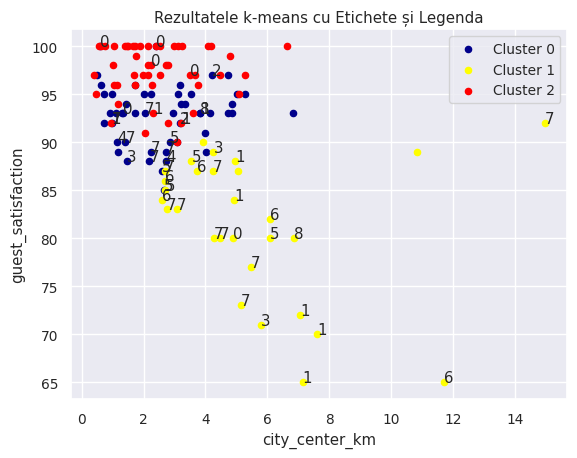

In [60]:
# Reprezentarea grafică a clusterelor, în funcție de două caracteristici numerice

ax = airbnb_df_[airbnb_df_["Cluster"] == 0][0:50].plot(kind='scatter', x='city_center_km', y='guest_satisfaction', color='DarkBlue', label='Cluster 0');
airbnb_df_[airbnb_df_["Cluster"] == 1][0:50].plot(kind='scatter', x='city_center_km', y='guest_satisfaction', color='Yellow', label='Cluster 1', ax=ax);
airbnb_df_[airbnb_df_["Cluster"] == 2][0:50].plot(kind='scatter', x='city_center_km', y='guest_satisfaction', color='Red', label='Cluster 2', ax=ax);
#airbnb_df_[airbnb_df_["Cluster"] == 3][0:50].plot(kind='scatter', x='city_center_km', y='guest_satisfaction', color='Green', label='Cluster 3', ax=ax);

for i in range(50):
    ax.annotate(round(airbnb_df_.iloc[i]["city"]), (airbnb_df_.iloc[i]['city_center_km'], airbnb_df_.iloc[i]['guest_satisfaction']))

plt.title('Rezultatele k-means')
plt.legend()
plt.show()

Unde:

  0 - Budapesta
  1 - Roma
  2 - Atena
  3 - Paris
  4 - Amsterdam
  5 - Lisabona
  6 - Berlin
  7 - Viena
  8 - Barcelona

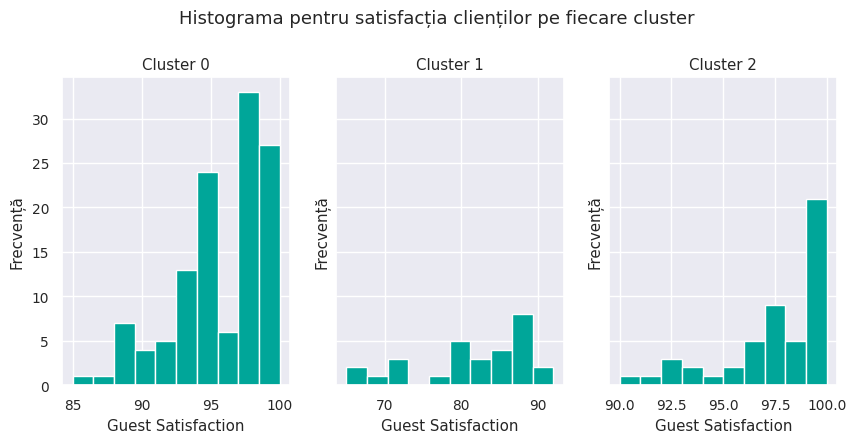

In [61]:
# Crearea subploturilor
fig, axs = plt.subplots(1, 3, figsize=(10, 4), sharey=True)
cluster_color = "#00A699"

# Trasarea histogramelor pentru fiecare cluster
for cluster in range(3):
    cluster_data = airbnb_df_[airbnb_df_["Cluster"] == cluster]
    axs[cluster].hist(cluster_data['guest_satisfaction'], label=f'Cluster {cluster}', color=cluster_color)
    axs[cluster].set_title(f'Cluster {cluster}')

for ax in axs:
    ax.set_xlabel('Guest Satisfaction')
    ax.set_ylabel('Frecvență')

plt.suptitle('Histograma pentru satisfacția clienților pe fiecare cluster', y=1.05)
plt.show()


***INTERPRETARE***

Pentru clusterele 2 și 3 se remarcă o împărțire aproximativ egală a instanțelor în funcție de satisfacția clienților pentru locuințele în care au stat, spre deosebire de primul cluster care are o frecvență mai mare pentru valorile ridicate ale satisfacției.

În al doilea cluster au fost incluse orașele cu cea mai mică satisfacție adusă clienților, spre deosebire de clusterul 3, în care au fost incluse preponderent orașe cu un nivel mediu al satisfacției și primul cluster în care au fost incluse orașele ce au adus cea mai mică satisfacție călătorilor.

In [62]:
#Coeficientul Silhouette
print(f"Silhouette Coefficient: {silhouette_score(airbnb_df_, labels):.3f}")

Silhouette Coefficient: -0.082


### Concluzii:



*	Pentru persoanele ce caută o destinație de vacanță ieftină, despre care călătorii sunt mulțumiți în ceea ce privește locuința aleasă prin platforma Airbnb, orașul ideal ar putea fi Atena, în timp ce pentru persoanele ce pun accentul pe curățenie, orașul potrivit ar putea fi Viena
*	Din analiza de regresie, rezultă faptul că satisfacția clienților este direct influențată de preț, în sensul în care cu cât apartamentul a fost mai scump, cu atât și satisfacția a crescut, motivul fiind că prețul este justificat de facilitățile locuinței, de capacitatea persoanelor, în sensul în care accentul satisfacției se pune și pe numărul de persoane cu care pot împărți locuința, iar un alt factor esențial este distanța până la o stație de metrou, între care există o legătură inversă. Astfel, dacă locuința este mai departe de metrou, satisfacția acestuia scade cu o unitate.
*	Modelul de regresie ce folosește XGBoost este mai performant decât un model de regresie liniară multiplă, explicația fiind proprietățile modelului de a se adapta mai ușor pe orice tip de date.
*	Cu toate acestea, ambele modele de regresie prezintă o calitate bună, comparand valorile coeficientului de determinare R2, însă așa cum era de așteptat, nu se respectă toate cele 7 ipoteze ale modelului de regresie liniară multifactorială.
*	În urma analizei de grupare, am împărțit observațiile, ținând cont de oraș și toate caracteristicile numerice, în 3 clustere, unde Roma și Viena s-au grupat ca fiind orașe cu un preț mediu, comparativ cu celelalte orașe, în care pot fi cazate aprox. 5 persoane și foarte curate
*	Paris și Amsterdam au fost grupate în alt cluster, fiind considerate mai ieftine, dar care au o rată a curățeniei foarte scăzută, și fiind foarte departe de metrou
*
	Budapesta ar putea fi destinația ideală a persoanelor care își doresc să călătorească singure, sau în cuplu de 2 persoane, fiind locuințe apropiate de stații de metrou, curate, dar cu un preț mai ridicat


